# Used Packages

In [44]:
import os
import shutil
import random

import pandas as pd
import spacy
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib

In [50]:
css = """
.output {
    display: flex;
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

In [85]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["cornflowerblue","lime"], gamma=0.75)

# Model Creation

In [2]:
PATH = 'data'
# set this parameter if you want to train another model
TRAIN_NEW_MODEL = False
NEW_MODEL_NAME = 'imdb2'

##  Dataset

In [3]:
# downloading the imdb dataset (if not already done)
# removing the unnecessary unsup folder because this is a supervised ml task
if not os.path.isdir('data'):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                        untar=True, cache_dir=PATH,
                                        cache_subdir='')

    shutil.rmtree('unsup')

In [4]:
# setting the directory for the training and test data
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

### Dataset Parameters

In [5]:
# setting model parameters
# autotune allows the automatic setting of the number of prefetched data ahead
# of time they are requested in the learning process
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
epochs = 1
seed = 42
init_lr = 3e-5

### Splitting Dataset

In [6]:
# training set 80 percent of all files with 20 left for validation
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)

test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Model Training

In [7]:
if TRAIN_NEW_MODEL:
    # setting the bert encoder and preprocessor
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

    # generating the bert encoder and preprocess layer for the model
    # (save model error can be fixed by deleting temp folder)
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)

    # function for building the classifiert model 
    # text input -> preprocessing -> encode -> droput -> dense 

    def build_classifier_model():
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
        encoder_inputs = preprocessing_layer(text_input)
        encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
        outputs = encoder(encoder_inputs)
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
        return tf.keras.Model(text_input, net)

    # initialize classifier model
    classifier_model = build_classifier_model()

    # set loss and metric functions
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    # create model hyperparameter optimizer
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

    # early stopping 
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss')

    # compile the model
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

    # train the model
    history = classifier_model.fit(x=train_ds,
                                validation_data=val_ds,
                                epochs=epochs)

In [8]:
if TRAIN_NEW_MODEL:
    loss, accuracy = classifier_model.evaluate(test_ds)

In [9]:
if TRAIN_NEW_MODEL:
    saved_model_path = f'./models/{NEW_MODEL_NAME}_bert'
    classifier_model.save(saved_model_path, include_optimizer=False)

# Loading the Model and working with it

In [10]:
if not TRAIN_NEW_MODEL:
    saved_model_path = f'models/{os.listdir("models")[1]}'
    model = tf.keras.models.load_model(saved_model_path, compile=False)
else: 
    model = classifier_model

## Get complete test data

In [11]:
test_data_unbatched = list(test_ds.unbatch().as_numpy_iterator())

## Select random pair

In [12]:
rand_ind = random.randint(0, len(test_data_unbatched))
rand_sen_label_pair = test_data_unbatched[rand_ind]
rand_sen_label_pair[0]
# rand_sen_label_pair = ('Just a boring and uninspired film filled with bad acting.', 0)

b'***POSSIBLE SPOILERS BELOW*** <br /><br />What a long and mostly uninteresting movie! Who were these characters? Why didn\'t I care about them? If I\'m going to watch a movie for two hours, I\'d like to care about somebody or something. <br /><br />We know that Salvatore dreamed of the riches to be found in the new world. Beyond that, though, we learned little about most of his family\'s hopes, fears, etc., as they embarked on an adventure into the unknown.<br /><br />And why was Lucy even in this movie? She said little; we knew little about her or what she was doing (was she forced to service men in exchange for being allowed to board the ship?) or what her plans were upon reaching New York. To those who might suggest that she was needed to underscore the point that a single woman, however cultured, could not get into this country alone, I say that that fact is not enough justification to give her so much screen time. That point could have been made in five minutes, with Lucy as a m

### Function for Text Classification

In [168]:
def classify_text(model, text, parent_ind=None, child_ind=None):
    '''
    Function to predict a given text given a model. 
    The predicted score is furthermore transformed into the corresponding 
    label.
    '''
    score = tf.sigmoid(model(tf.constant([text])))[0][0].numpy()
    pred_label = np.where(score > 0.5, 1, 0).item()

    if parent_ind or child_ind:
        return (score, pred_label, parent_ind, child_ind)
    else:
        return (score, pred_label)

## Predict random pair

In [169]:
org_text_pred = classify_text(model, rand_sen_label_pair[0])
print(f'Predicted Label: {org_text_pred[1]} \nScore: {org_text_pred[0]} \nReal Label: {rand_sen_label_pair[1]}')

Predicted Label: 0 
Score: 0.12521302700042725 
Real Label: 0


## Dependecy Parser

In [170]:
depend_parser = spacy.load('en_core_web_sm')

In [171]:
parsed_text = depend_parser(str(rand_sen_label_pair[0]))
sentence_spans = list(parsed_text.sents)[0]

In [172]:
spacy.displacy.render(sentence_spans, jupyter=True, options={"compact": True})

### Functions for Text Generation

In [173]:
def leave_n_out(text):
    '''
    Function for generating texts from an original text, where every 
    text is missing a different parent-child-word-combination of 
    the original text.

    Go over all words, if a word has children, then for every parent-child-pair
    return a text with both removed.
    '''
    leave_n_out_texts = []

    for parent_to_remove in text:
        childList = [child for child in parent_to_remove.children]

        if childList:
            for child_to_remove in childList:
                new_text = []

                for word in text:
                    if (word.i != parent_to_remove.i and 
                        word.i != child_to_remove.i):
                            new_text.append(word.text)

                leave_n_out_texts.append(
                    (" ".join(new_text), parent_to_remove.i, child_to_remove.i))

    return leave_n_out_texts


def leave_one_out(text):
    '''
    Function for generating texts from an original text, where 
    every text is missing one different word of the original text.
    '''
    leave_one_out_texts = []

    for word_to_remove in text:
        new_text = []

        for word in text:
            if word_to_remove.i != word.i:
                new_text.append(word.text)

        leave_one_out_texts.append(
            (" ".join(new_text), word_to_remove.i, None))

    return leave_one_out_texts


### Functions for Further Processing

In [174]:
def drop_unimportant_words(df, label, org_score):
    '''
    Function to drop unimportant words.
    An unimportant word is one which increases 
    the difference of the classificaion with out it vs. with it .

    For example: "The movie was very good." 
    Score: 0.9
    Score without "the": 0.95

    "The" is unimportant, because the classification without it increases.
    '''
    if label == 1:
        df = df.drop(df.index[df['Score'] >= org_score] )
    else:
        df = df.drop(df.index[df['Score'] <= org_score] )

def calc_score_diff(df, label, org_score):
    '''
    Function to calculate the score differences of the original text to 
    those with certain words removed.
    '''
    if label == 1:
        df['Score Difference'] = org_score - df['Score']
    else:
        df['Score Difference'] = df['Score'] - org_score

def create_df(texts):
    '''
    Function to create a dataframe out of a given list of texts. 
    The constructed dataframe consists of four columns: 
    Score, Predicted Label, Parent Index and Child Index.

    The values for all columns come from the classify_text function.
    '''

    df = pd.DataFrame(
        [classify_text(model, text[0], text[1], text[2]) for text in texts],
        columns=['Score',
                 'Predicted Label',
                 'Parent Index',
                 'Child Index'])

    return df

def linearize_score_diff(df, choose_best_diff=False):
    '''
    Function to linearize the score differences in a given dataframe. 
    If choose_best_score flag is set, the best difference for every 
    token is choosen. 

    For example: 
    If the word "good" is a child of the word "movie" and the word "story"
    the best score difference of both pairs is choosen. If "good" happens
    to be a parent with children itself, all those possible pairs are 
    considered either for best difference. 
    '''
    if choose_best_diff:
        df_copy = df.copy()
        df_copy[['Child Index', 'Parent Index']
                ] = df[['Parent Index', 'Child Index']]
        df = pd.concat([df, df_copy]).reset_index(drop=True)
        df = df.loc[df.groupby(['Parent Index'])[
            "Score Difference"].idxmax()]

    df['Score Difference'] = MinMaxScaler(
    ).fit_transform(df[['Score Difference']])

    df.drop(
        ["Score", "Predicted Label", "Child Index"],
        inplace=True, axis=1)

    df = df.sort_values(by=['Score Difference'])

    df.rename(columns={"Parent Index": "Token Index"}, inplace=True)

    return df


### Functions for Visualization

In [175]:
def vis_text(df):
    '''
    Function which creates a plt plot without axis of a given text
    with given word importances. 

    It draws all words in a row, creating a new one whenever the current 
    row is to full. Words are colored given the corresponding importance 
    in the dataframe. 
    
    If a word is not given in the dataframe, for example if it was removed 
    due to not contributing to the classification, it is colored white.
    '''
    start_x = 20
    start_y = 500
    end = 1200
    whitespace = 8

    figure = plt.figure(figsize=(20, 10))
    rend = figure.canvas.get_renderer()

    for token in parsed_text:
        if df.loc[df["Token Index"] == token.i, 'Score Difference'].values.size > 0:
            col = cmap(df.loc[df["Token Index"] == token.i, 'Score Difference'].values[0])
        else: 
            col = "white"
        bbox = dict(boxstyle="round,pad=0.3", fc=col, ec="white")

        txt = plt.text(start_x, start_y, str(token), bbox=bbox, transform=None)

        bb = txt.get_window_extent(renderer=rend)

        start_x = bb.width + start_x + whitespace

        if start_x >= end:
            start_x = 20
            start_y -= 20

    plt.axis("off")
    plt.show()

## Generating New Texts

In [176]:
new_texts_lno = leave_n_out(parsed_text)
new_texts_loo = leave_one_out(parsed_text)

## Generating DataFrames

In [177]:
df_lno = create_df(new_texts_lno)
df_loo = create_df(new_texts_loo)

display(df_lno)
display(df_loo)

,Score,Predicted Label,Parent Index,Child Index
0,0.045647,0,1,0
1,0.021876,0,1,2
2,0.018619,0,1,3
3,0.018619,0,1,4
4,0.018619,0,1,5
...,...,...,...,...
403,0.014493,0,423,428
404,0.014493,0,428,424
405,0.014493,0,428,425
406,0.014493,0,428,426


,Score,Predicted Label,Parent Index,Child Index
0,0.018941,0,NaN,None
1,0.013765,0,1.0,None
2,0.016406,0,2.0,None
3,0.012930,0,3.0,None
4,0.012930,0,4.0,None
...,...,...,...,...
426,0.014493,0,426.0,None
427,0.014493,0,427.0,None
428,0.014493,0,428.0,None
429,0.014493,0,429.0,None


## Dropping Unimportant Words

In [178]:
drop_unimportant_words(df_lno, org_text_pred[1], org_text_pred[0])
drop_unimportant_words(df_loo, org_text_pred[1], org_text_pred[0])

## Calculating Score Differences

In [179]:
calc_score_diff(df_lno, org_text_pred[1], org_text_pred[0])
calc_score_diff(df_loo, org_text_pred[1], org_text_pred[0])

## Linearizing Score Difference

In [180]:
df_lno = linearize_score_diff(df_lno, choose_best_diff=True)
df_loo = linearize_score_diff(df_loo)

display(df_lno)
display(df_loo)

,Token Index,Score Difference
416,12,0.000000
455,67,0.019114
468,69,0.034796
60,68,0.034796
489,87,0.048784
...,...,...
0,1,0.651986
408,0,0.651986
9,11,0.654318
10,14,1.000000


,Token Index,Score Difference
11,11.0,0.000000
68,68.0,0.025155
29,29.0,0.057003
12,12.0,0.059948
8,8.0,0.068605
...,...,...
75,75.0,0.296428
73,73.0,0.314229
52,52.0,0.323005
9,9.0,0.719523


### Visualize Texts

Leave n out:


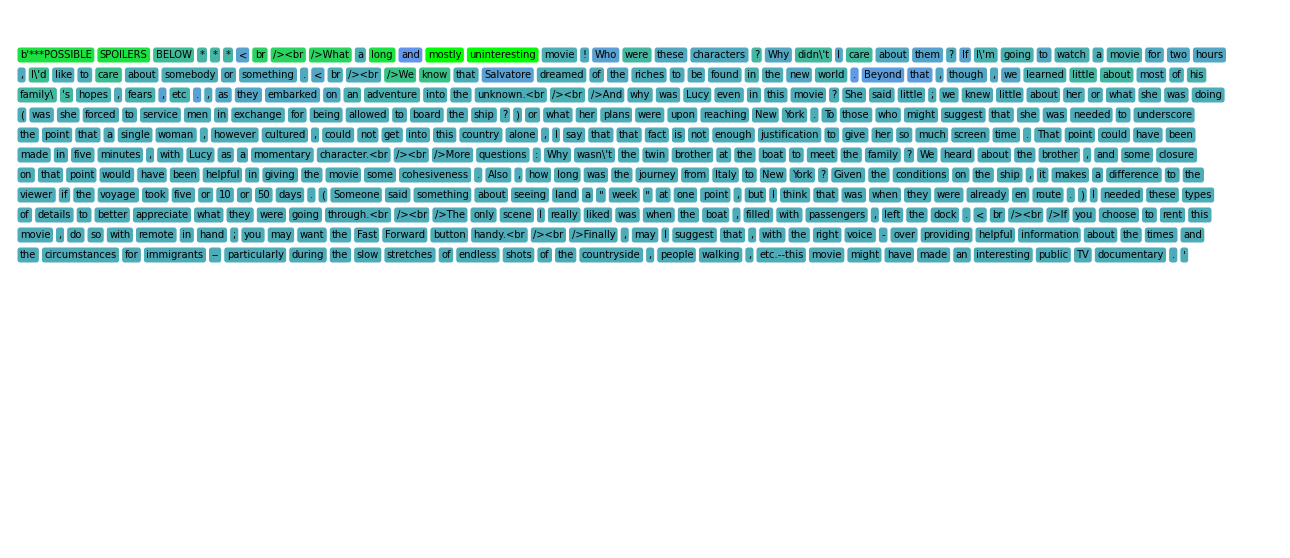

Leave one out:


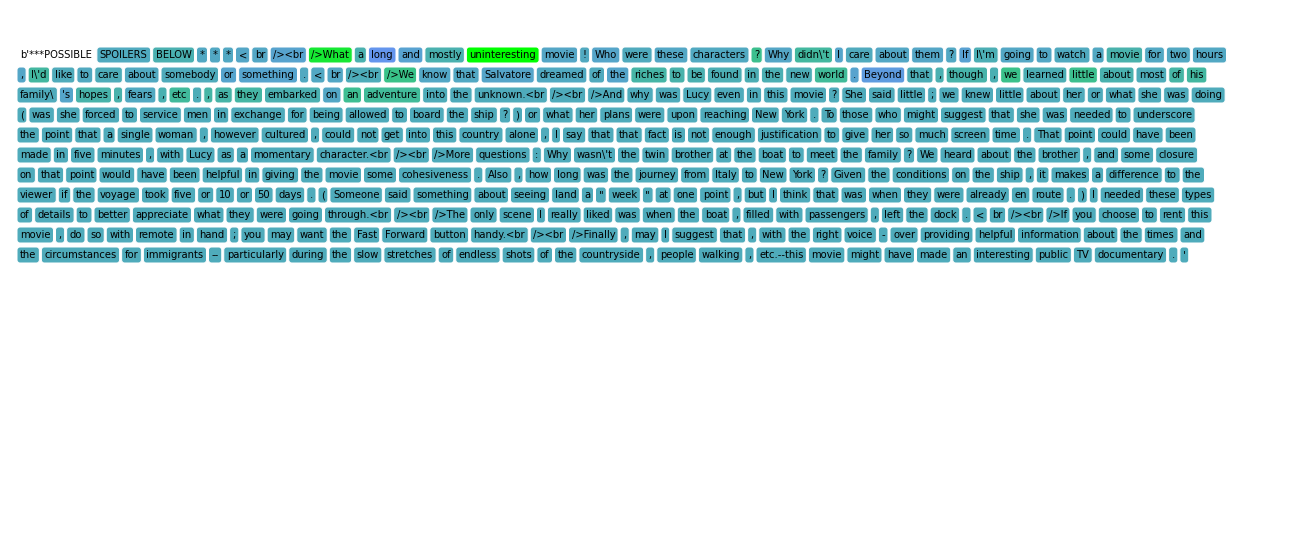

In [181]:
print('Leave n out:')
vis_text(df_lno)
print('Leave one out:')
vis_text(df_loo)